<a href="https://colab.research.google.com/github/ewapajak/ML/blob/main/homework08_automatic_gradient_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Working with Other Loss Functions**

-------------------------------

During the class today, we reconstructed an **ellipse**. The ellipse was defined with two **foci** and $C$ (the sum of distances of the ellipse points from the foci).

To reconstruct the ellipse through optimization, we began with **$N$ points** scattered randomly in the 2D plane. Our goal was to adjust their positions so that they satisfy the elliptical constraint as closely as possible. We achieved this by minimizing the **error-related loss**, $L^{(2)}_{\text{ellipse}}$ which was defined in today's class with $\ell_2$ norm as:

$$
L^{(2)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \epsilon_i^2
$$

where
$$
 \epsilon_i = d_{i1} + d_{i2} - C
$$
where $N$ is the number of points, and $d_{i1}, d_{i2}$ are their distances to the two foci.

In the homework assignment you will experiment with 3 other loss definitions based on some other possible norms.

##**Imports and plot_results definition**:
I will use the code from our class

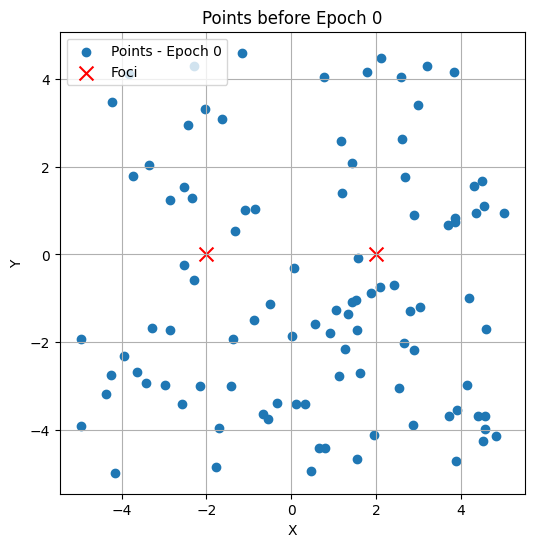

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True



def plot_results(epoch, trajectories, loss_history=None):
    if loss_history is not None:
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    else:
      fig, axes = plt.subplots(1, 1, figsize=(6, 6))
      axes = [axes]
    points = np.array([trajectories[i][-1] for i in range(num_points)])
    # Left plot: Scatter of points with trajectories
    axes[0].scatter(points[:, 0], points[:, 1], label=f'Points - Epoch {epoch}')
    f1 = focus1.detach().cpu().numpy()
    f2 = focus2.detach().cpu().numpy()
    axes[0].scatter([f1[0], f2[0]], [f1[1], f2[1]], color='red', marker='x', s=100, label='Foci')

    # Draw movement traces
    for i in range(num_points):
        trajectory = np.array(trajectories[i])
        axes[0].plot(trajectory[:, 0], trajectory[:, 1], color='gray', linestyle='-', linewidth=0.5)

    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].legend()


    axes[0].grid()

    if loss_history is not None:
      axes[0].set_title(f'Points after Epoch {epoch}')
      # Right plot: Loss history
      axes[1].plot(loss_history, color='blue')
      axes[1].set_xlabel("Epoch")
      axes[1].set_ylabel("Loss")
      axes[1].set_title("Loss Convergence")
      axes[1].grid()
    else:
      axes[0].set_title(f'Points before Epoch {epoch}')

    plt.show()

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []

for i in range(num_points):
    trajectories[i].append(points[i].detach().cpu().clone().numpy())

plot_results(0, trajectories, None)


##**The norms**:



1. $\ell_0$ norm resulting in
  $$
  L^{(0)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(\epsilon_i \neq 0)
  $$
  - If you actually succeed to code this loss function, the question for you to answer in relation to $L^{(0)}_{\text{ellipse}}$ is why the training is not progressing with passing epochs.
  - If you actually fail to code this loss function, the question for you to answer is to explain the failure and reason out theoretically, why the training would not be progressing with passing epochs, anyway.

##**Idea**:

In [ ]:
dist1 = torch.norm(points - focus1, dim=1)
dist2 = torch.norm(points - focus2, dim=1)
loss = torch.sum((dist1 + dist2 - constant_sum != 0).float())

This approach would be correct. The problem is that the loss function implemented as in the code above is not differentiable. The indicator function created a binary tensor; as a result, `loss.backward()` fails. Let's try another approach and implement the loss function using a smooth and differentiable approximation of the $L_{0}$ norm.



$$Loss = \sum_{i=1}^{N}\frac{|\epsilon_{i}|}{|\epsilon_{i}|+δ}$$ <br>
where $ \epsilon_i = d_{i1} + d_{i2} - C$ and $\delta$ is a small value.

- For large values $|x_{i}|$ our loss function approaches 1:

$$\frac{|\epsilon_{i}|}{|\epsilon_{i}|+δ} \approx 1 $$

- For values $|x_{i}|$ near zero our loss function approaches 0:

$$ \frac{|\epsilon_{i}|}{|\epsilon_{i}|+δ} \approx \frac{0}{\delta} = 0 $$

Therefore the function behaves similarly to an indicator.


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []


import time
# Start timing
start_time = time.time()


# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute distances to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    # Compute loss - it is implemented as MSE loss related to l_2 norm
    # TODO: your job is to replace the line below
    # with l_0, l_1 and l_infty - related loss
    eps = 1e-6
    loss = torch.sum(torch.abs(dist1 + dist2 - constant_sum) / (torch.abs(dist1 + dist2 - constant_sum) + eps))

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

#Final plot
plot_results(epoch, trajectories, loss_history)


# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

The $L_{0}$ norm loss is discrete and a non-differentiable funtion, therefore it doesn't have a gradient and the algorith doesn't have a gradient it could follow.

To work around this problem we introduced a smooth approximation of the $L_{0}$ norm loss - a differentiable function, which technically should allow backpropagation. Yet, our results show that this loss still fails to converge.

As our point get closer to the ellipse, $ \epsilon_i = d_{i1} + d_{i2} - C$ values approach 0, and so does the gradient, resulting in small optimizer steps and very weak convergence.

We can observe that our code produced a sharply shaped loss convergence plot. Its shape can be attributed to the discrete nature of our norm. This behaviour leads us to conclude that the convergence is not only slow, but also unstable, lacking smoothness, even though we implemented a smoothened version of our loss function.


2. $\ell_1$ norm resulting in
  $$
  L^{(1)}_{\text{ellipse}} = \frac{1}{N} \sum_{i=1}^{N} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(1)}_{\text{ellipse}}$ is why the training loss doesn't converge, even after the ellipse has been fully drawn.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []


import time
# Start timing
start_time = time.time()


# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute distances to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    # Compute loss - it is implemented as MSE loss related to l_2 norm
    # TODO: your job is to replace the line below
    # with l_0, l_1 and l_infty - related loss
    loss = torch.mean(torch.abs(dist1 + dist2 - constant_sum))

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

#Final plot
plot_results(epoch, trajectories, loss_history)


# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

The $L_{1}$ norm loss is almost everywhere differentiable (except for zero). Due to its non-smooth nature at zero, as our $ \epsilon_i = d_{i1} + d_{i2} - C$ residuals approach zero, the optimizer encounters changes in the gradient direction, resulting in irregular and unstable update steps, especially noticable in the last stages of our optimization. Unlike the $L_{2}$ loss, which we observed in class to converge smoothly, the $L_{1}$ loss fluctuates near zero, without setting. Consequently, despite the points forming a visually appealing ellipse, the convergence is poor and unstable.

3. $\ell_\infty$ norm resulting in
  $$
  L^{(\infty)}_{\text{ellipse}} =  \max_{i} |\epsilon_i|
  $$
  The question for you to answer in relation to $L^{(\infty)}_{\text{ellipse}}$ is why the training takes so long and it doesn't converge in the end, either.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Initialize random 2D points from uniform distribution
num_points = 100
points = torch.rand((num_points, 2)) * 10 - 5  # Uniformly distributed in [-5, 5]
points.requires_grad = True

# Reset trajectories
trajectories = [[] for _ in range(num_points)]
loss_history = []


import time
# Start timing
start_time = time.time()


# Define optimizer
optimizer = torch.optim.Adam([points], lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute distances to both foci
    dist1 = torch.norm(points - focus1, dim=1)
    dist2 = torch.norm(points - focus2, dim=1)

    # Compute loss - it is implemented as MSE loss related to l_2 norm
    # TODO: your job is to replace the line below
    # with l_0, l_1 and l_infty - related loss
    loss = torch.max(torch.abs(dist1 + dist2 - constant_sum))

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Store current positions for tracking movement
    for i in range(num_points):
        trajectories[i].append(points[i].detach().cpu().clone().numpy())

    # Plot results every 10th epoch
    if epoch % 10 == 0:
        plot_results(epoch, trajectories, loss_history)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

#Final plot
plot_results(epoch, trajectories, loss_history)


# End timing
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

The $L_{∞}$ norm captures only the largest error across all point, making it particularly sensitive to outliers, slowing down the optimization process. During training, the model prioritizes correcting just the worst-off points rather than improving the dataset as a whole. As a result, the convergence is slow and inefficient - it takes significantly more epochs (compared to $L_1$ or $L_2$ loss) to form a recognizable ellipse. Furthermore, as the maximum error approaches zero, the gradient becomes unstable, which again, leads to irregular and 'squiggly' updates and unstable convergence behaviour.